In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy,math


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
x_df=pd.read_csv("/content/drive/MyDrive/CyberLabs_ML/linear_regression_train.csv", header=0)

x_train_df=x_df.iloc[0:48000,1:26]
y_train_df=x_df.iloc[0:48000,26:27]
print(y_train_df.head(5))
print(x_train_df.head(5))
print(x_train_df.shape)
print(x_train_df.size)



        Target
0  5235.690928
1 -1221.442146
2 -1102.758862
3   437.940266
4   755.825367
   Feature_1  Feature_2  Feature_3   Feature_4  Feature_5  Feature_6  \
0 -10.429837  21.684251  93.056324  128.914740   1.657315 -34.602633   
1  12.475081  11.652011 -47.621889  -21.892583 -25.844861 -46.951253   
2   7.696188  24.729547  43.782383  -53.282523 -69.145794 -57.072335   
3   6.505033  22.092605 -25.161422    4.742729 -20.344550 -50.248793   
4   5.906445  19.909180  24.705865  -51.875251 -24.857500 -25.879977   

    Feature_7   Feature_8   Feature_9  Feature_10  ...  Feature_16  \
0  -70.314374  -89.585318  -98.465642   32.708495  ...  -16.592030   
1 -114.500805  -96.257473 -138.354981    3.507057  ...  -22.893133   
2 -114.149171 -105.408739  -71.892560   66.893460  ...   -2.406405   
3  -89.324731 -104.002016 -160.103875    7.199201  ...  -23.511275   
4  -37.787560  -99.587673  -47.929647   58.730086  ...  -22.131232   

   Feature_17  Feature_18  Feature_19  Feature_20  Featu

In [4]:
x_arr=x_train_df.values
y_arr=y_train_df.values
print(x_arr.shape)
print(x_arr.dtype)
print(y_arr.shape)
print(type(y_arr))
print(type(x_arr))

(48000, 25)
float64
(48000, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [5]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return (X_norm, mu, sigma)

X_norm, X_mu, X_sigma = zscore_normalize_features(x_arr)

In above cell, we took the values in the Dataframe to form NumPy array for ease in performing vectorised operations later.

In [6]:
def predict(x, w, b):
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters
      b (scalar):             model parameter

    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b
    return p

In [7]:
b_init = 785.1811367994083
w_init = np.random.rand(25)
print(f"w_init: {w_init}, b_init type: {type(b_init)}")

w_init: [0.27707766 0.51932395 0.01936035 0.17071766 0.27419521 0.20307121
 0.3483247  0.80082391 0.98724403 0.03617156 0.14099806 0.85834559
 0.64152883 0.42352973 0.28291686 0.05988324 0.24646067 0.99024814
 0.6992028  0.99798895 0.84250035 0.45985919 0.05007543 0.3918025
 0.33602024], b_init type: <class 'float'>


In [8]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar
    return cost

In [9]:
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for linear regression
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b.
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        err = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err * X[i, j]
        dj_db = dj_db + err
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

In [10]:
import copy
import math
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,)) : Updated values of parameters
      b (scalar)       : Updated value of parameter
      """

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)


        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i}: Cost {J_history[-1]}, w: {w}, b:{b}")

    return w, b, J_history #return final w,b and J history for graphing

In [ ]:

# initialize parameters
initial_w = np.array([ 98.88384853,   5.59834367, 410.84713848, 575.67716304,   0.72391922,
 641.82111026, 351.396115,     2.97973987, 508.41629563, 179.73250638,
   1.87543403,   3.0238292,  595.82835865, 520.4700557,   -3.19812813,
 414.65791489,  20.48795162, 357.80366259, 324.63325696, 546.45949511,
  70.22676325,  -2.41939597,  83.59325066, 388.99118235,  -0.87819205])
initial_b = 1149.66347705
# some gradient descent settings
iterations = 500
alpha = 5.0e-2
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_norm, y_arr, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)

#print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
print(f"b,w found by gradient descent: {b_final},{w_final} ")
m,_ = x_arr.shape
for i in range(5):
    print("prediction:", np.dot(x_arr[i], w_final) + b_final,"target value:", y_arr[i][0])

<ipython-input-9-9fd3148af50d>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dj_dw[j] = dj_dw[j] + err * X[i, j]


Iteration 0: Cost [155535.75449457], w: [100.32687891   5.50978693 416.37765508 583.50520626   0.69392576
 650.33521682 356.00656411   2.89688032 515.27647631 182.06685435
   1.85602983   2.97326475 603.9537231  527.48331484  -3.18197592
 420.24100176  20.90295951 362.5433801  328.99350268 553.8061302
  71.35701846  -2.34516113  84.68747065 394.159403    -0.84266918], b:[1154.52924047]
Iteration 50: Cost [58634.44462628], w: [ 1.27597701e+02  1.62889713e+00  5.14275983e+02  7.23047776e+02
 -2.49823853e-01  7.99029314e+02  4.35823958e+02 -2.66581963e-01
  6.36743597e+02  2.22099368e+02  9.97638900e-01  8.28275998e-01
  7.49178701e+02  6.51568508e+02 -1.85494671e+00  5.18947329e+02
  3.02742220e+01  4.45402563e+02  4.05933904e+02  6.83609374e+02
  9.40643172e+01  4.89750046e-01  1.03855908e+02  4.84542158e+02
  4.99774302e-01], b:[1239.86522051]
Iteration 100: Cost [58031.21462359], w: [ 1.30187220e+02  7.57106947e-01  5.22071656e+02  7.34346271e+02
 -4.06092205e-01  8.10347843e+02  4.41

In [14]:
# initialize parameters
initial_w = np.array([ 1.30450010e+02,  6.30887596e-01,  5.22752875e+02,  7.35341443e+02,
 -4.23493990e-01,  8.11285219e+02,  4.42198532e+02, -1.00613918e+00,
  6.47193384e+02,  2.25168305e+02,  7.86963176e-01,  2.90427137e-01,
  7.62095443e+02,  6.62220237e+02, -1.41987882e+00,  5.27387257e+02,
  3.16658716e+01,  4.52260766e+02,  4.12490636e+02,  6.94742158e+02,
  9.67826403e+01,  1.15877636e+00,  1.05488175e+02,  4.92027124e+02,
  8.04727135e-01])
initial_b = 1246.97874537
# some gradient descent settings
iterations = 30
alpha = 5.0e-2
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_norm, y_arr, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)

#print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
print(f"b,w found by gradient descent: {b_final},{w_final} ")
m,_ = x_arr.shape
for i in range(5):
    print("prediction:", np.dot(x_arr[i], w_final) + b_final,"target value:", y_arr[i][0])


<ipython-input-9-9fd3148af50d>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dj_dw[j] = dj_dw[j] + err * X[i, j]


Iteration 0: Cost [58027.40024312], w: [ 1.30450010e+02  6.30887596e-01  5.22752875e+02  7.35341443e+02
 -4.23493990e-01  8.11285219e+02  4.42198532e+02 -1.00613918e+00
  6.47193384e+02  2.25168305e+02  7.86963176e-01  2.90427136e-01
  7.62095443e+02  6.62220237e+02 -1.41987882e+00  5.27387257e+02
  3.16658716e+01  4.52260766e+02  4.12490636e+02  6.94742158e+02
  9.67826403e+01  1.15877636e+00  1.05488175e+02  4.92027124e+02
  8.04727135e-01], b:[1246.97874537]
Iteration 3: Cost [58027.40024312], w: [ 1.30450010e+02  6.30887595e-01  5.22752875e+02  7.35341443e+02
 -4.23493990e-01  8.11285219e+02  4.42198532e+02 -1.00613918e+00
  6.47193384e+02  2.25168305e+02  7.86963175e-01  2.90427135e-01
  7.62095443e+02  6.62220237e+02 -1.41987882e+00  5.27387257e+02
  3.16658716e+01  4.52260766e+02  4.12490636e+02  6.94742158e+02
  9.67826403e+01  1.15877636e+00  1.05488175e+02  4.92027124e+02
  8.04727135e-01], b:[1246.97874537]
Iteration 6: Cost [58027.40024312], w: [ 1.30450010e+02  6.30887594e

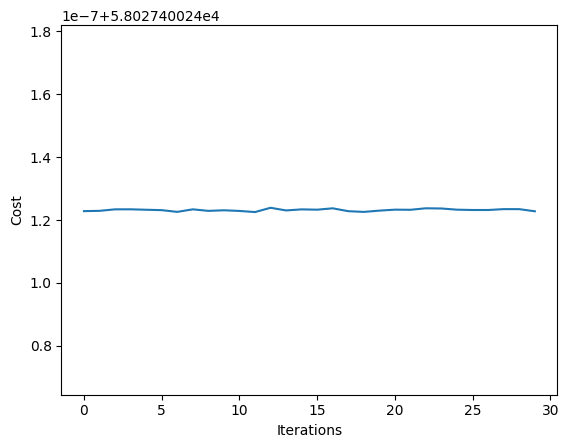

In [26]:
J_arr=np.array(J_hist)
J_arr1=J_arr.reshape(30)

iterations=np.arange(30)
plt.plot(iterations,J_arr1)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


Since, the cost function appears to converge with more iterations. Thus we have reached our best fitting.

In [32]:
test_df=pd.read_csv("/content/drive/MyDrive/CyberLabs_ML/linear_regression_test.csv", header=0)
x_test=test_df.iloc[:,1:27].values
print(x_test.shape)

x_test_n, X_mu2, X_sigma2 = zscore_normalize_features(x_test)
print(x_test_n.shape)

(12000, 25)
(12000, 25)


In [34]:
y_pred=predict(x_test_n,w_final,b_final)
print(y_pred.shape)

y_pred_df=pd.DataFrame(y_pred)

(12000,)


In [35]:
y_pred_df.to_csv("Linear_regression_output.csv", index=False)


In [36]:
! ls

drive  Linear_regression_output.csv  sample_data


In [37]:
! cat Linear_regression_output.csv

Streaming output truncated to the last 5000 lines.
-209.05924890546953
4518.798975949052
114.43839348232791
2255.3187031036314
4142.916823539085
-1348.32564867036
-1198.636055800955
-2312.145456780881
3780.6212938971858
4163.459961211382
1519.5284765189017
1527.23389102976
-213.41428926130516
2296.7527902076445
1028.5033878286292
-802.9529968201232
4030.543110607464
3347.987266968319
-721.5049250751499
5727.412851544195
2465.878752456052
1970.0708133548192
2826.158778156258
-3425.51746959054
4846.214505828602
370.6946084189466
4368.698082301489
-198.29930645667218
-1406.6618303784016
3025.8149727977525
2744.4034893086673
2035.65767688783
3481.4280829383397
249.29993463601033
-749.4184360930142
4044.69803724056
3673.2109326496366
-22.964079773944377
1658.6379478735607
-1953.5983985165526
1355.6985392272245
2025.5442883698774
-240.0246853748347
1094.2680931113223
-1846.3659986079333
1614.3398850811247
-3364.1303717527435
802.6065713839811
1708.2210269170896
1210.6939818944359
-725.668226